In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sn
from matplotlib import pyplot as plt

import copepodTCR as cpp
import codepub as cdp

import tqdm
import time

# Figure-1: In silico simulations

**Figure-1D** Sensitivity and specificity of the activation model improve with increasing $mu_{\text{signal}}$ and decreasing scaling factor. Results shown are from 12,960 independent simulations.

In [2]:
table = pd.read_csv('./data/insilico_validation.tsv',
                    sep = "\t", low_memory=False)
control = table[table['error'] == 100]
table = table[table['error'] != 100]
print(f'Negative data: {len(control)}')
print(f'Data: {len(table)}')

Negative data: 6480
Data: 12960


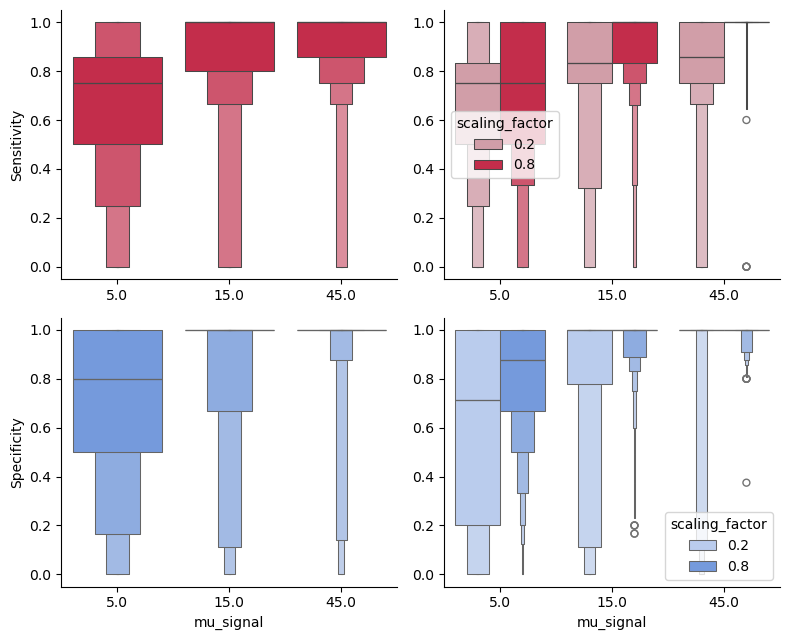

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6.5))

sn.boxenplot(y = table['TPR'], x = table['mu_signal'], ax=axes[0, 0], color = '#DC143C')
sn.boxenplot(y = 1 - table['FPR'], x = table['mu_signal'], ax=axes[1, 0], color = '#6495ED')

axes[0, 0].set_ylabel('Sensitivity')
axes[1, 0].set_ylabel('Specificity')
axes[0, 0].set_xlabel('')
axes[1, 0].set_xlabel('mu_signal')

sn.boxenplot(data = table, y = 'TPR', x = table['mu_signal'], ax=axes[0, 1], hue = 'scaling_factor',
             palette = ['#DA95A3', '#DC143C'])
sn.boxenplot(data = table, y = 1 - table['FPR'], x = table['mu_signal'], ax=axes[1, 1], hue = 'scaling_factor',
             palette = ['#B1CAF6', '#6495ED'])

axes[0, 1].set_ylabel('')
axes[1, 1].set_ylabel('')

axes[0, 1].set_xlabel('')
axes[1,1 ].set_xlabel('mu_signal')

sn.despine()

plt.tight_layout()

**Figure-1E** Sensitivity and specificity are a function of the expected share of negative pools and the distance between the mean of the negative and positive pool intensities ($mu_{\text{signal}}$). The share of negative pools equals $\frac{N - I - E + 1}{N}$, where $N$ is the total number of pools, $I$ is peptide occurrence (number of pools to which one peptide is added), and $E$ is the number of peptides sharing one epitope. The vertical dashed line indicates the experimentally recommended share of negative pools. Negative data: specificity for simulations where all pools were sampled from the negative distribution. Results shown are from 12,636 independent simulations, including 4,212 negative data simulations.

In [4]:
table_ns = pd.read_csv('./data/insilico_validation_negshare.tsv', sep = "\t")
control_ns = table_ns[table_ns['error'] == 100]
table_ns = table_ns[table_ns['error'] != 100]
print(f'Negative data: {len(control_ns)}')
print(f'Data: {len(table_ns)}')

Negative data: 4212
Data: 8424


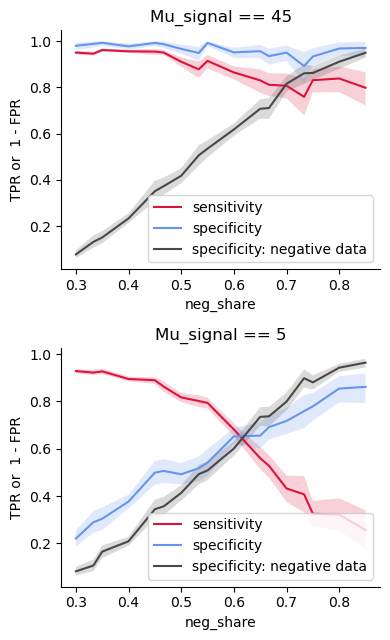

In [5]:
fig, axes = plt.subplots(2, 1, figsize = (4, 6.5))

ax = axes[0]
d1 = table_ns[table_ns['mu_signal'] == 45]
sn.lineplot(data = d1, x = 'neg_share', y = 'TPR', color = 'Crimson', label = 'sensitivity', ax = ax)
sn.lineplot(data = d1, x = 'neg_share',
            y = 1 - d1['FPR'], color = 'CornflowerBlue', label = 'specificity', ax = ax)
c1 = control_ns[control_ns['mu_signal'] == 45]
sn.lineplot(data = c1, x = 'neg_share',
            y = 1 - c1['FPR'], color = '#484848', label = 'specificity: negative data', ax = ax)
ax.set_ylabel('TPR or  1 - FPR')
ax.set_title('Mu_signal == 45')

ax = axes[1]
d1 = table_ns[table_ns['mu_signal'] == 5]
sn.lineplot(data = d1, x = 'neg_share',
            y = 'TPR', color = 'Crimson', label = 'sensitivity', ax = ax)
sn.lineplot(data = d1, x = 'neg_share',
            y = 1 - d1['FPR'], color = 'CornflowerBlue', label = 'specificity', ax = ax)
c1 = control_ns[control_ns['mu_signal'] == 5]
sn.lineplot(data = c1, x = 'neg_share',
            y = 1 - c1['FPR'], color = '#484848', label = 'specificity: negative data', ax = ax)
ax.set_ylabel('TPR or  1 - FPR')
ax.set_title('Mu_signal == 5')

for ax in axes:
    for collection in ax.collections:
        collection.set_edgecolor("none")

sn.despine()
plt.tight_layout()

The number of possible candidates depends on the number of tested peptides and the number of erroneous non-activated pools. Results display a simulation with 18 pools and 6 pools per peptide and epitope presence in two consecutive peptides. For zero erroneously non-activated pools, the algorithm returns two peptides whose shared sequence contains the cognate epitope.

In [6]:
simulation_results_fixN18_fixI6 = pd.read_csv('./data/errors_fixN18_fixI6.tsv',
                                              sep = "\t")

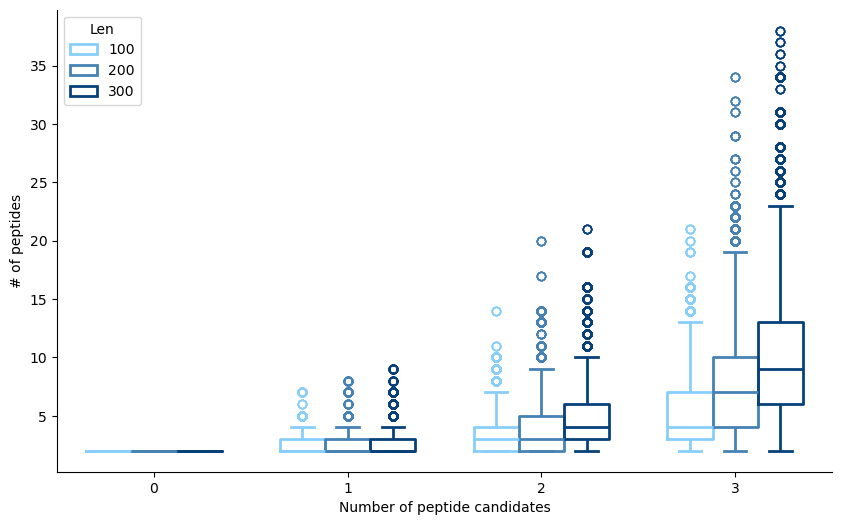

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sn.boxplot(data = simulation_results_fixN18_fixI6[simulation_results_fixN18_fixI6['# of lost'] < 4],
                x = '# of lost', y = '# of peptides', hue = 'Len',
                palette = ['#87CEFA', '#4682B4', '#08417A'], fill = False, linewidth = 2, width = 0.7)
ax.set_xlabel('Number of erroneous non-activated pools')
ax.set_xlabel('Number of peptide candidates')
sn.despine()

# Figure-2: CopepodTCR design successfully recapitulates known TCR specificity.

Experimental and model results of a CCP assay with copepodTCR for the T cell reporter cell lines expressing DPB1*04:(01/02)-restricted TCR6.3 and HLA-A02+ restricted YLQ-TCR1 with their known, cognate peptides indicated in blue letters in the peptide sequence.

In [8]:
exp_data_fc = pd.read_csv('./data/FC_TCR6_YLQ_activation.tsv',
                      sep = "\t")
exp_data_m = pd.read_csv('./data/M_TCR6_YLQ_activation.tsv',
                      sep = "\t")
cpp_scheme = pd.read_csv('./data/epitope_simulation_results.tsv', sep = "\t")
peptides = list(pd.read_csv('./data/peptides.tsv', sep = "\t", header = None)[0])

ep_length = 8
n_pools = 12
iters = 4

### TCR6.3

**Figure-2C** Bayesian mixture model (blue and orange) of observed (black) pool activation signal for the read out obtained by flow cytometry.

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [negative, offset_proportion, p, sigma_neg, sigm_pos, pool_dist, sigma_data]
>BinaryGibbsMetropolis: [assign]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
/Users/kovaleva/miniforge3/envs/copepodTCR/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 374 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [lik, negative_obs]


Output()

Posterior mean of p: 0.572
No drop-outs were detected
['SSANNCTFEYVSQPFLM', 'CTFEYVSQPFLMDLEGK']
['SSANNCTFEYVSQPFLM', 'CTFEYVSQPFLMDLEGK']


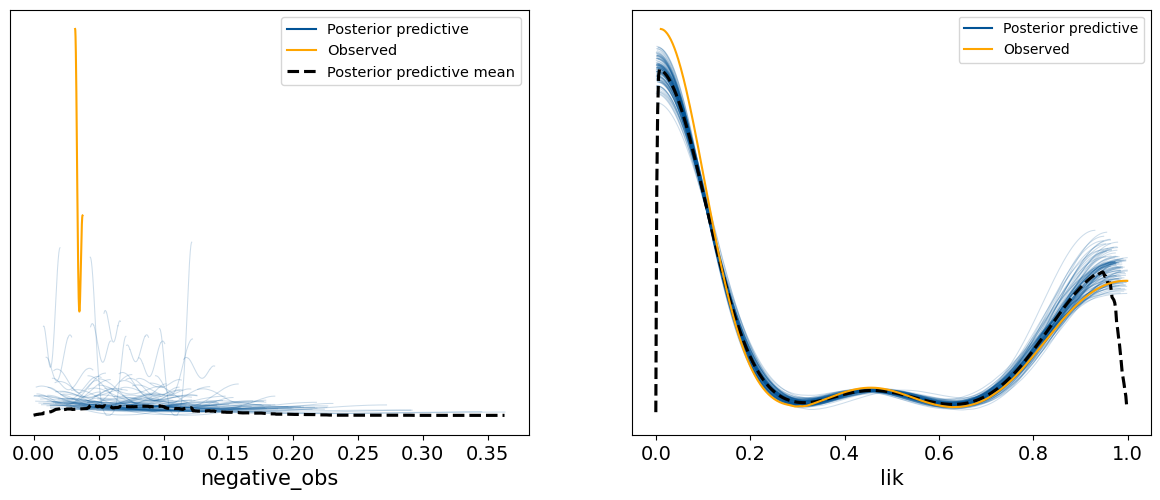

In [9]:
# /100 because there are percentages
obs = np.array(exp_data_fc['TCR6_3_fc(%)'][exp_data_fc['type'] == 'pool'])/100
inds = np.array(exp_data_fc['Pool'][exp_data_fc['type'] == 'pool']).astype(int)
neg_f1 = np.array(exp_data_fc['TCR6_3_fc(%)'][exp_data_fc['Pool'] == 'unstim'])/100

t, r = cpp.how_many_peptides(peptides, ep_length)
e = max(t, key=t.get)
neg_share = (n_pools - iters - e + 1)/n_pools

model, fig, probs, n_c, pp, parameters = cpp.activation_model(obs, n_pools, inds, neg_f1, neg_share = neg_share)
peptide_probs = cpp.peptide_probabilities(cpp_scheme, probs)
n_act_pools, message, most, possible = cpp.results_analysis(peptide_probs, probs, cpp_scheme)
print(message)
print(most)
print(possible)

**Figure-2A** Flow cytometry read out as percentage of GFP-producing (activated) cells in the T cell activation assay (y-axis) for each pool in the design (x-axis), with pools detected as activated/non-activated in green and gray, respectively (determined from model fit above).

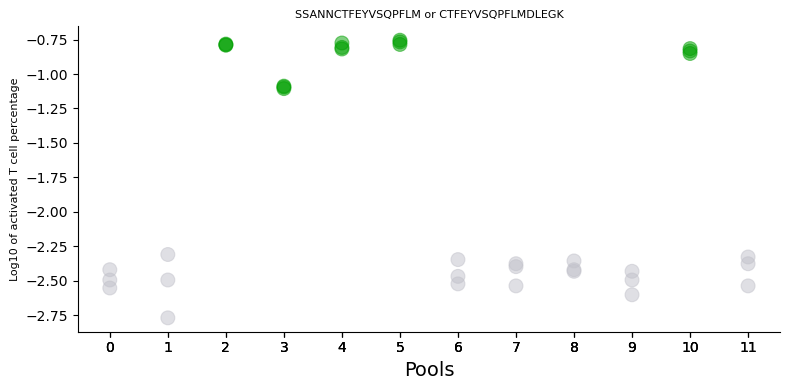

In [10]:
cpp.poolplot(probs, obs, inds, most)

**Figure-2B** Inferred probability of each measurement coming from the distribution of activated pools (green) and from a distribution of non-activated pools (gray).

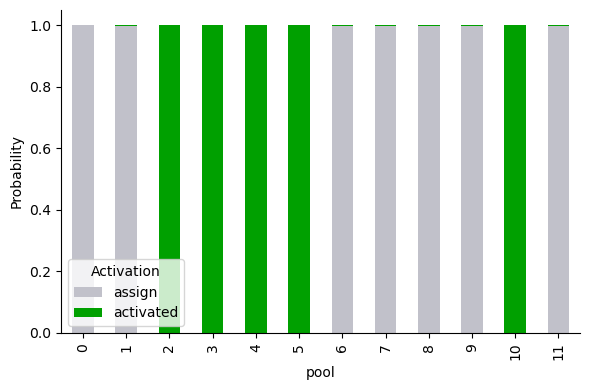

In [11]:
probs['activated'] = 1-probs['assign']
ax = probs.plot(kind="bar", stacked=True, figsize=(6, 4), color=["#C1C1CA", "#00A000"])
plt.legend(title="Activation")
plt.ylabel('Probability')
plt.tight_layout()
sn.despine()

**Figure-2D** Per-peptide probabilities calculated from model. The size of the circle shows the difference between the number of activated and non-activated pools to which a peptide was added.

In [12]:
cpp.set_seed(123)
# reload the cell if it is not displayed
import plotly.io as pio
pio.renderers.default = "notebook_connected"
fig = cpp.hover_bubbleplot(peptide_probs)
fig.show()

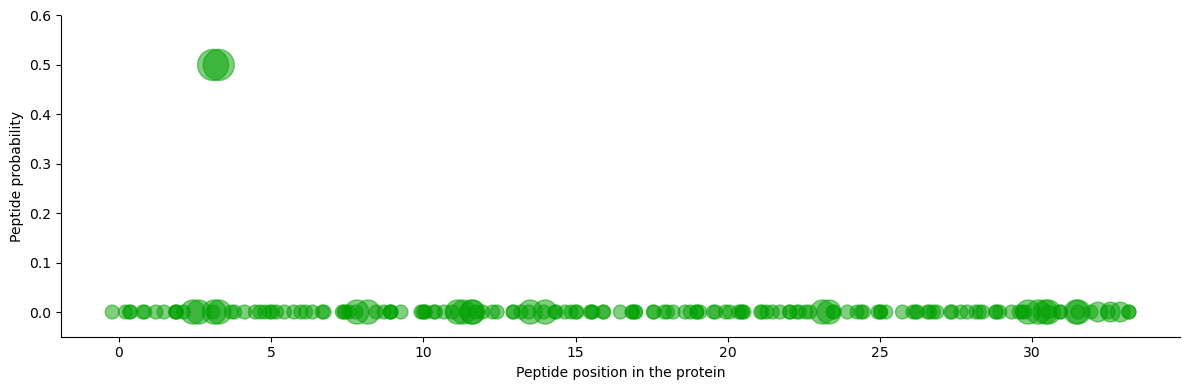

In [13]:
cpp.bubbleplot(peptide_probs)
sn.despine()

**Figure-2E** Sensitivity of the assay. Left: activation of the cell line by PMA/ionomycin, single cognate peptide and baseline activation levels without peptide stimulation. Right: The activation signal from all pools mixed together (1x, all pools mixed), and a 5-fold (5x), or 25-fold (25x) dilution thereof. All dilutions show activation levels above unstimulated negative control.

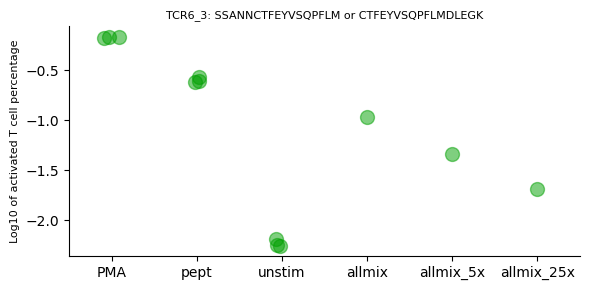

In [14]:
x_order = ['PMA', 'pept', 'unstim', 'allmix', 'allmix_5x', 'allmix_25x']

plt.figure(figsize=(6, 3))
ax = sn.stripplot(x = exp_data_fc['Pool'][exp_data_fc['type'] == 'control'],
                  y = np.log10(exp_data_fc['TCR6_3_fc(%)'][exp_data_fc['type'] == 'control']/100), color = '#00A000',
                  order = x_order, s = 10, edgecolor = '#00A000', linewidth = 1, alpha = 0.5)
ax.set_title(f'TCR6_3: {most[0]} or {most[1]}', fontsize=8)
ax.set_ylabel('Log10 of activated T cell percentage', fontsize=8)
ax.set_xlabel('', fontsize=14)

sn.despine()
plt.tight_layout()

**Figure-2F** Correlation of flow cytometry and microscopy-based read out of the T cell activation assay.

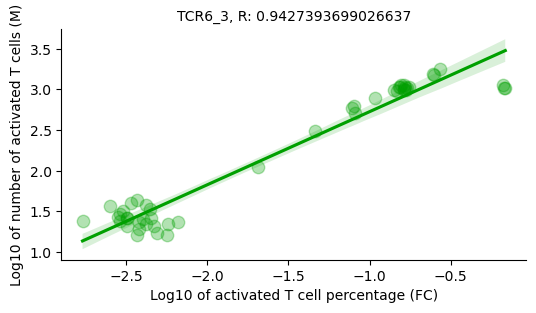

In [15]:
fig, axes = plt.subplots(figsize = (6, 3))
cells_fc = list(exp_data_fc['TCR6_3_fc(%)']/100)
cells_m = list(exp_data_m['TCR6_3_m(#)'])
ax = sn.regplot(x = np.log10(cells_fc), y = np.log10(cells_m),
                color = '#00A000', scatter_kws={'s': 80, 'alpha': 0.3})

correlation_coefficient, p_value = stats.pearsonr(np.log10(cells_fc), np.log10(cells_m))


ax.set_title(f'TCR6_3, R: {correlation_coefficient**2}', fontsize=10)
ax.set_ylabel('Log10 of number of activated T cells (M)')
ax.set_xlabel('Log10 of activated T cell percentage (FC)')
sn.despine()

### YLQ_TCR1

**Figure-2C** Bayesian mixture model (blue and orange) of observed (black) pool activation signal for the read out obtained by flow cytometry.

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [negative, offset_proportion, p, sigma_neg, sigm_pos, pool_dist, sigma_data]
>BinaryGibbsMetropolis: [assign]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [lik, negative_obs]


Output()

Posterior mean of p: 0.590
Drop-out was detected
['GAAAYYVGYLQPRTFLL', 'YVGYLQPRTFLLKYNEN']
['SGWTAGAAAYYVGYLQP', 'KNLNESLIDLQELGKYE', 'GAAAYYVGYLQPRTFLL', 'ATKMSECVLGQSKRVDF', 'SLIDLQELGKYEQYIKW', 'ECVLGQSKRVDFCGKGY', 'YVGYLQPRTFLLKYNEN']


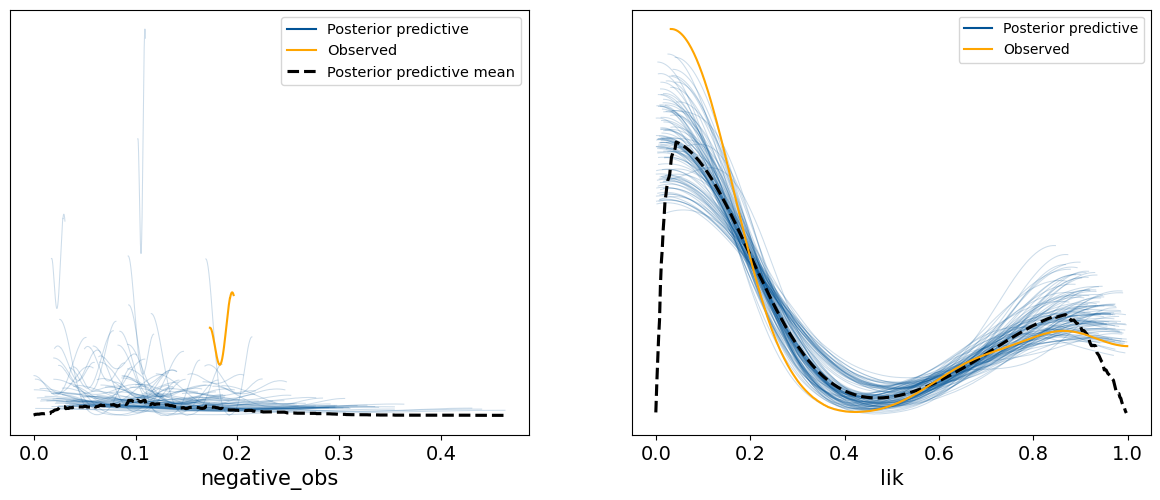

In [16]:
# /100 because there are percentages
obs = np.array(exp_data_fc['YLQ_TCR1_fc(%)'][exp_data_fc['type'] == 'pool'])/100
inds = np.array(exp_data_fc['Pool'][exp_data_fc['type'] == 'pool']).astype(int)
neg_f1 = np.array(exp_data_fc['YLQ_TCR1_fc(%)'][exp_data_fc['Pool'] == 'unstim'])/100

t, r = cpp.how_many_peptides(peptides, ep_length)
e = max(t, key=t.get)
neg_share = (n_pools - iters - e + 1)/n_pools

model, fig, probs, n_c, pp, parameters = cpp.activation_model(obs, n_pools, inds, neg_f1, neg_share = neg_share)
peptide_probs = cpp.peptide_probabilities(cpp_scheme, probs)
n_act_pools, message, most, possible = cpp.results_analysis(peptide_probs, probs, cpp_scheme)
print(message)
print(most)
print(possible)

**Figure-2A** Flow cytometry read out as percentage of GFP-producing (activated) cells in the T cell activation assay (y-axis) for each pool in the design (x-axis), with pools detected as activated/non-activated in green and gray, respectively (determined from model fit above).

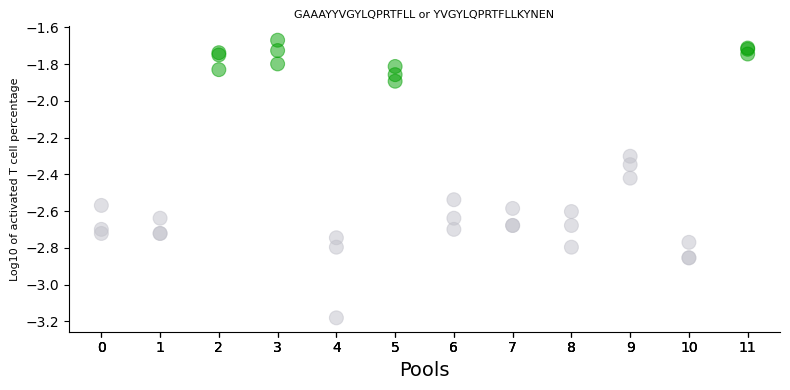

In [17]:
cpp.poolplot(probs, obs, inds, most)

**Figure-2B** Inferred probability of each measurement coming from the distribution of activated pools (green) and from a distribution of non-activated pools (gray).

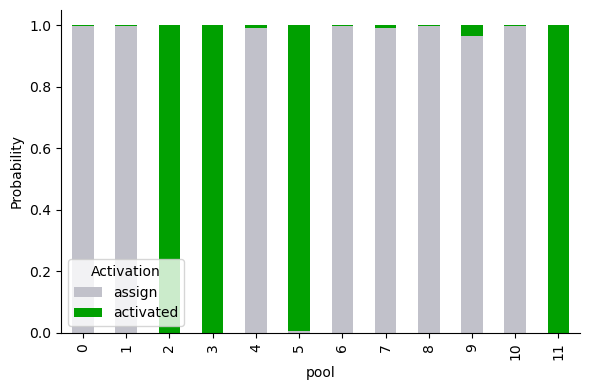

In [18]:
probs['activated'] = 1-probs['assign']
ax = probs.plot(kind="bar", stacked=True, figsize=(6, 4), color=["#C1C1CA", "#00A000"])
plt.legend(title="Activation")
plt.ylabel('Probability')
plt.tight_layout()
sn.despine()

**Figure-2D** Per-peptide probabilities calculated from model. The size of the circle shows the difference between the number of activated and non-activated pools to which a peptide was added.

In [19]:
cpp.set_seed(123)
# reload the cell if it is not displayed
import plotly.io as pio
pio.renderers.default = "notebook_connected"
fig = cpp.hover_bubbleplot(peptide_probs)
fig.show()

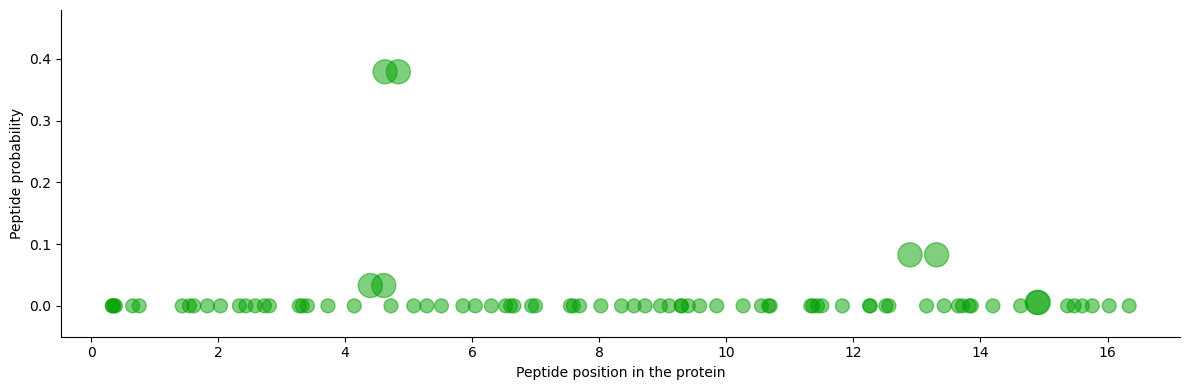

In [20]:
cpp.bubbleplot(peptide_probs)
sn.despine()

**Figure-2E** Sensitivity of the assay. Left: activation of the cell line by PMA/ionomycin, single cognate peptide and baseline activation levels without peptide stimulation. Right: The activation signal from all pools mixed together (1x, all pools mixed), and a 5-fold (5x), or 25-fold (25x) dilution thereof. All dilutions show activation levels above unstimulated negative control.

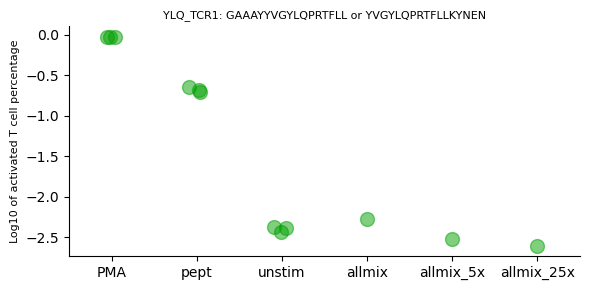

In [21]:
x_order = ['PMA', 'pept', 'unstim', 'allmix', 'allmix_5x', 'allmix_25x']

plt.figure(figsize=(6, 3))
ax = sn.stripplot(x = exp_data_fc['Pool'][exp_data_fc['type'] == 'control'],
                  y = np.log10(exp_data_fc['YLQ_TCR1_fc(%)'][exp_data_fc['type'] == 'control']/100), color = '#00A000',
                  order = x_order, s = 10, edgecolor = '#00A000', linewidth = 1, alpha = 0.5)
ax.set_title(f'YLQ_TCR1: {most[0]} or {most[1]}', fontsize=8)
ax.set_ylabel('Log10 of activated T cell percentage', fontsize=8)
ax.set_xlabel('', fontsize=14)

sn.despine()
plt.tight_layout()

**Figure-2F** Correlation of flow cytometry and microscopy-based read out of the T cell activation assay.

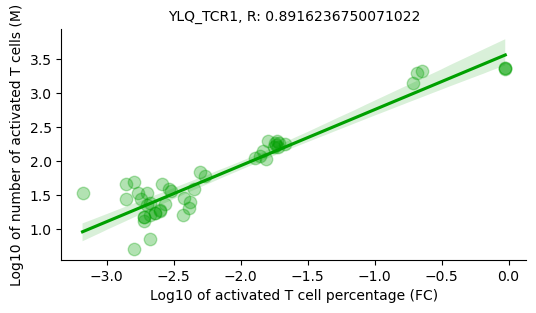

In [22]:
fig, axes = plt.subplots(figsize = (6, 3))
cells_fc = list(exp_data_fc['YLQ_TCR1_fc(%)']/100)
cells_m = list(exp_data_m['YLQ_TCR1_m(#)'])
ax = sn.regplot(x = np.log10(cells_fc), y = np.log10(cells_m),
                color = '#00A000', scatter_kws={'s': 80, 'alpha': 0.3})

correlation_coefficient, p_value = stats.pearsonr(np.log10(cells_fc), np.log10(cells_m))


ax.set_title(f'YLQ_TCR1, R: {correlation_coefficient**2}', fontsize=10)
ax.set_ylabel('Log10 of number of activated T cells (M)')
ax.set_xlabel('Log10 of activated T cell percentage (FC)')
sn.despine()

# Figure-3: CopepodTCR design identifies specificity of TCRs with unknown targets.

In [23]:
Lu_fc = pd.read_csv('./data/FC_Lu3_Lu4_activation.tsv', sep = "\t")
cpp_scheme = pd.read_csv('./data/epitope_simulation_results.tsv', sep = "\t")
peptides = list(pd.read_csv('./data/peptides.tsv', sep = "\t", header = None)[0])

ep_length = 8
n_pools = 12
iters = 4

### Lu3

**Figure-3C** Bayesian mixture model (blue and orange) of observed (black) pool activation signal for the read out obtained by flow cytometry.

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [negative, offset_proportion, p, sigma_neg, sigm_pos, pool_dist, sigma_data]
>BinaryGibbsMetropolis: [assign]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
/Users/kovaleva/miniforge3/envs/copepodTCR/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning:

invalid value encountered in scalar divide

There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [lik, negative_obs]


Output()

Posterior mean of p: 0.582
No drop-outs were detected
['LPFFSNVTWFHAIHVSG', 'NVTWFHAIHVSGTNGTK']
['LPFFSNVTWFHAIHVSG', 'NVTWFHAIHVSGTNGTK']


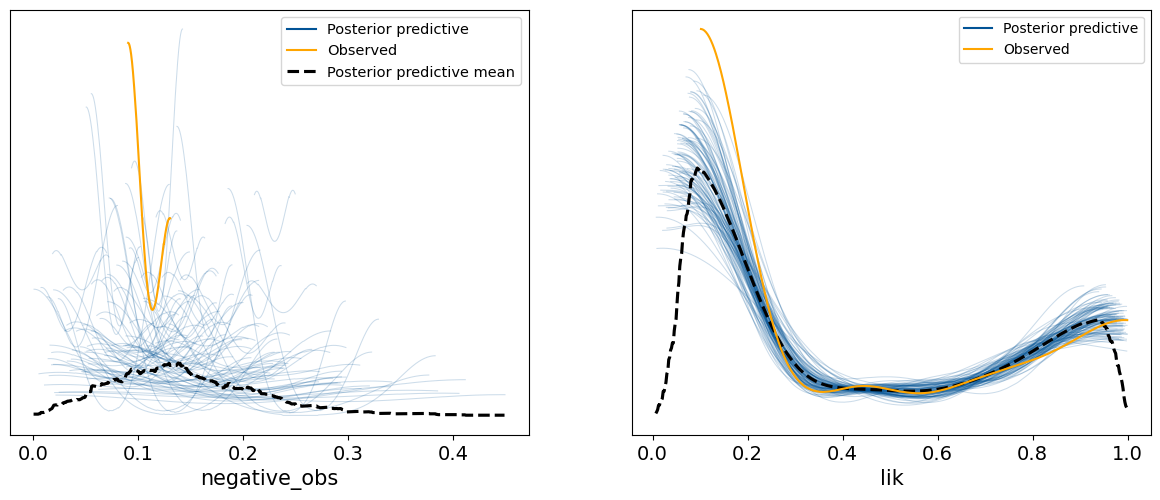

In [24]:
# /100 because these are percentages
obs = np.array(Lu_fc['Lu3_fc(%)'][Lu_fc['type'] == 'pool'])/100
inds = np.array(Lu_fc['Pool'][Lu_fc['type'] == 'pool']).astype(int)
neg_f1 = np.array(Lu_fc['Lu3_fc(%)'][Lu_fc['Pool'] == 'unstim'])/100

t, r = cpp.how_many_peptides(peptides, ep_length)
e = max(t, key=t.get)
neg_share = (n_pools - iters - e + 1)/n_pools

model, fig, probs, n_c, pp, parameters = cpp.activation_model(obs, n_pools, inds, neg_f1, neg_share = neg_share)
peptide_probs = cpp.peptide_probabilities(cpp_scheme, probs)
n_act_pools, message, most, possible = cpp.results_analysis(peptide_probs, probs, cpp_scheme)
print(message)
print(most)
print(possible)

**Figure-3A** Flow cytometry read out as percentage of GFP-producing (activated) cells in the T cell activation assay (y-axis) for each pool in the design (x-axis), with pools detected as activated/non-activated in green and gray, respectively.

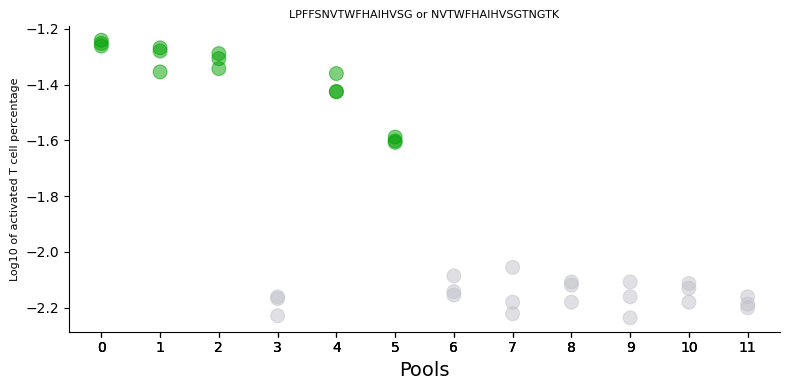

In [25]:
cpp.poolplot(probs, obs, inds, most)

**Figure-3B** Inferred probability of each measurement coming from the distribution of activated pools (green) and from a distribution of non-activated pools (gray).

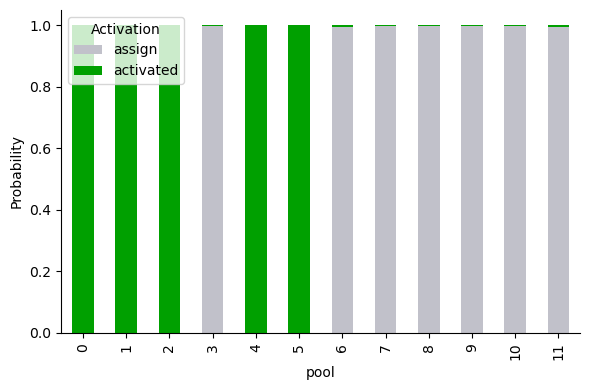

In [26]:
probs['activated'] = 1-probs['assign']
ax = probs.plot(kind="bar", stacked=True, figsize=(6, 4), color=["#C1C1CA", "#00A000"])
plt.legend(title="Activation")
plt.ylabel('Probability')
plt.tight_layout()
sn.despine()

**Figure-3D** Per-peptide probabilities calculated from B, where the probability of one peptide equals the product of probabilities of pools to which it was added and 1 - probabilities of pools to which it was not added. The size of the circle shows the difference between the number of activated and non-activated pools to which a peptide was added.

In [27]:
fig = cpp.hover_bubbleplot(peptide_probs)
fig.show()

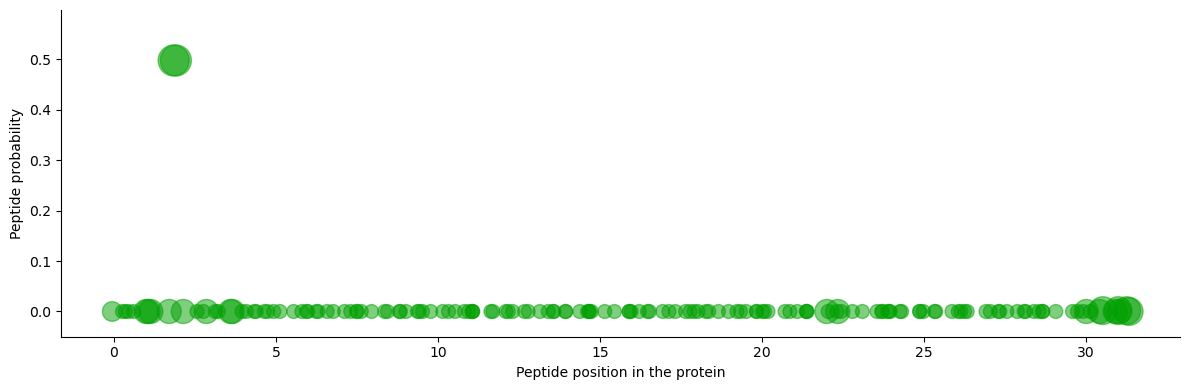

In [28]:
cpp.bubbleplot(peptide_probs)
sn.despine()

**Figure-3E** Both cell lines strongly recognize both individual overlapping peptides predicted from combinatorial pooling experiment. Recognition does not occur in presence of HLA-DR blocking antibody or if peptides are presented by DQB1:05:01-positive DRB1:16-negative donor (Aph34).

In [29]:
exp_restr = pd.read_csv('./data/Lu3_Lu4_restriction.tsv', sep = "\t")

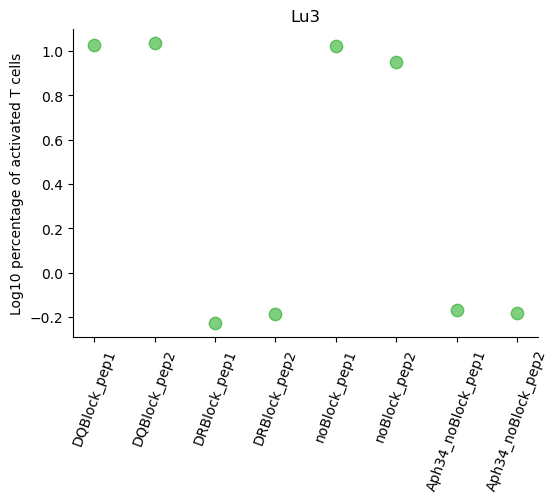

In [30]:
fig, axes = plt.subplots(figsize = (6, 4))
sn.scatterplot(x = exp_restr['type'], y = np.log10(exp_restr['Lu3_fc(%)']),
               s = 80, color = '#00A000', alpha = 0.5, edgecolor = '#00A000', linewidth = 1)
plt.xlabel('')
plt.ylabel('Log10 percentage of activated T cells')
plt.title('Lu3')
plt.xticks(rotation=70)
sn.despine()

### Lu4

**Figure-3C** Bayesian mixture model (blue and orange) of observed (black) pool activation signal for the read out obtained by flow cytometry.

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [negative, offset_proportion, p, sigma_neg, sigm_pos, pool_dist, sigma_data]
>BinaryGibbsMetropolis: [assign]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.
/Users/kovaleva/miniforge3/envs/copepodTCR/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning:

invalid value encountered in scalar divide

There were 501 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [lik, negative_obs]


Output()

Posterior mean of p: 0.593
No drop-outs were detected
['LPFFSNVTWFHAIHVSG', 'NVTWFHAIHVSGTNGTK']
['LPFFSNVTWFHAIHVSG', 'NVTWFHAIHVSGTNGTK']


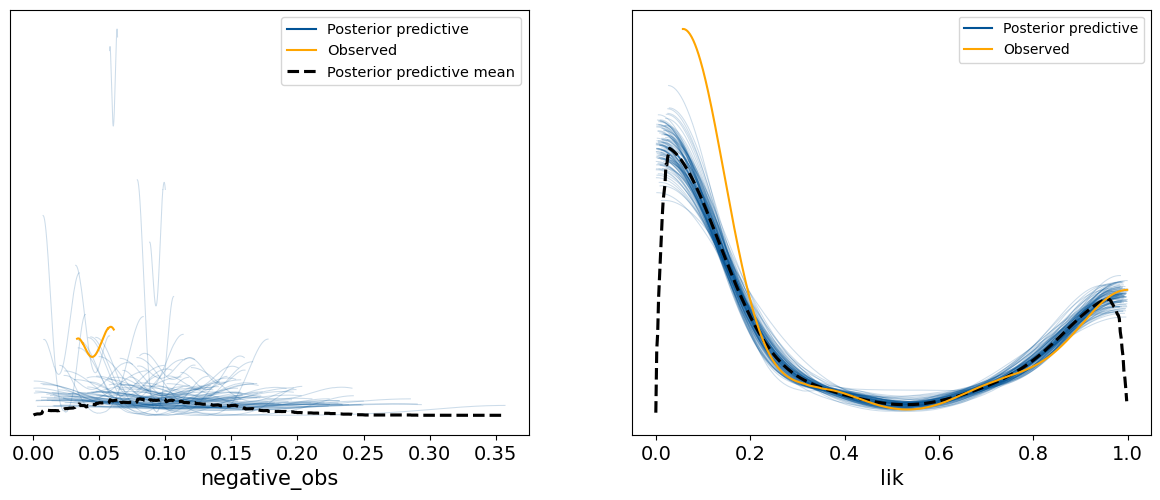

In [31]:
# /100 because these are percentages
obs = np.array(Lu_fc['Lu4_fc(%)'][Lu_fc['type'] == 'pool'])/100
inds = np.array(Lu_fc['Pool'][Lu_fc['type'] == 'pool']).astype(int)
neg_f1 = np.array(Lu_fc['Lu4_fc(%)'][Lu_fc['Pool'] == 'unstim'])/100

t, r = cpp.how_many_peptides(peptides, ep_length)
e = max(t, key=t.get)
neg_share = (n_pools - iters - e + 1)/n_pools

model, fig, probs, n_c, pp, parameters = cpp.activation_model(obs, n_pools, inds, neg_f1, neg_share = neg_share)
peptide_probs = cpp.peptide_probabilities(cpp_scheme, probs)
n_act_pools, message, most, possible = cpp.results_analysis(peptide_probs, probs, cpp_scheme)
print(message)
print(most)
print(possible)

**Figure-3A** Flow cytometry read out as percentage of GFP-producing (activated) cells in the T cell activation assay (y-axis) for each pool in the design (x-axis), with pools detected as activated/non-activated in green and gray, respectively

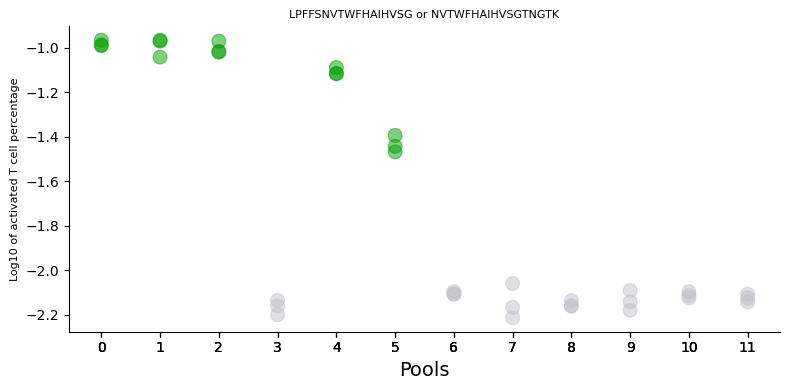

In [32]:
cpp.poolplot(probs, obs, inds, most)

**Figure-3B** Inferred probability of each measurement coming from the distribution of activated pools (green) and from a distribution of non-activated pools (gray).

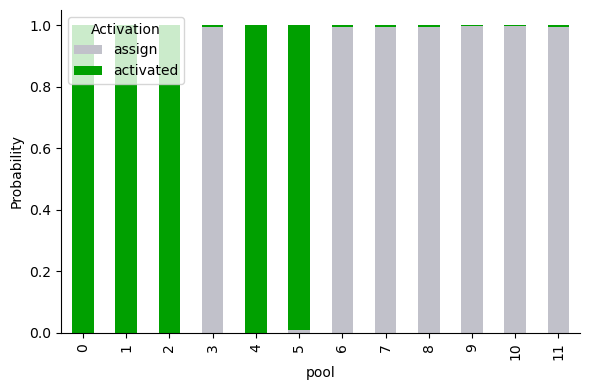

In [33]:
probs['activated'] = 1-probs['assign']
ax = probs.plot(kind="bar", stacked=True, figsize=(6, 4), color=["#C1C1CA", "#00A000"])
plt.legend(title="Activation")
plt.ylabel('Probability')
plt.tight_layout()
sn.despine()

**Figure-3D** Per-peptide probabilities calculated from B, where the probability of one peptide equals the product of probabilities of pools to which it was added and 1 - probabilities of pools to which it was not added. The size of the circle shows the difference between the number of activated and non-activated pools to which a peptide was added.

In [34]:
fig = cpp.hover_bubbleplot(peptide_probs)
fig.show()

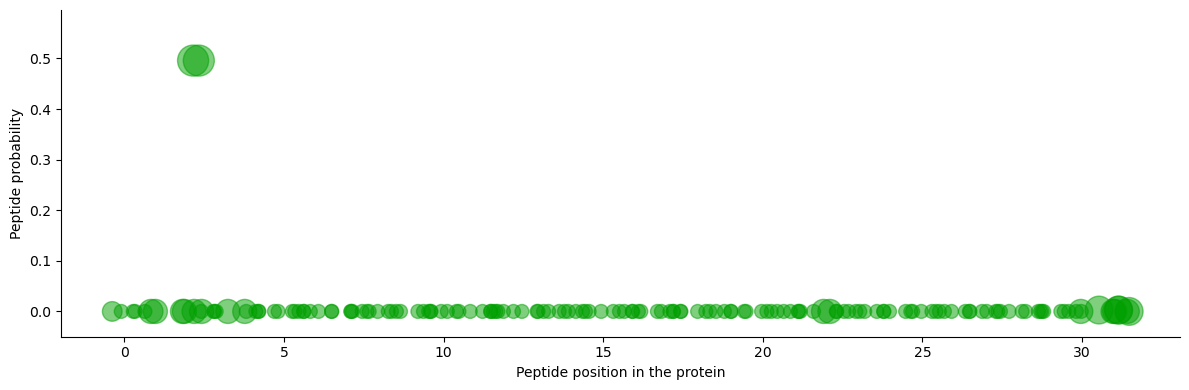

In [35]:
cpp.bubbleplot(peptide_probs)
sn.despine()

**Figure-3E** Both cell lines strongly recognize both individual overlapping peptides predicted from combinatorial pooling experiment. Recognition does not occur in presence of HLA-DR blocking antibody or if peptides are presented by DQB1:05:01-positive DRB1:16-negative donor (Aph34).

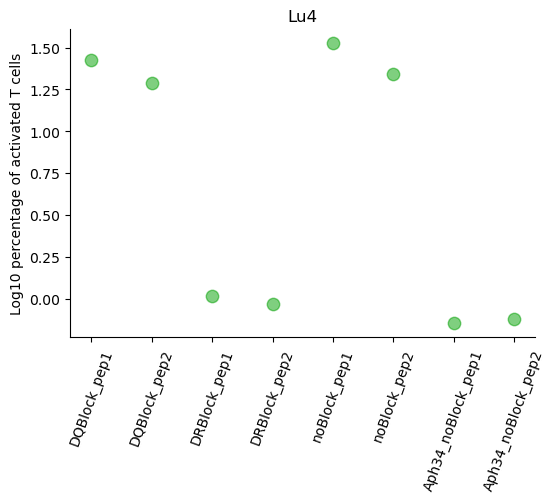

In [36]:
fig, axes = plt.subplots(figsize = (6, 4))
sn.scatterplot(x = exp_restr['type'], y = np.log10(exp_restr['Lu4_fc(%)']),
               s = 80, color = '#00A000', alpha = 0.5, edgecolor = '#00A000', linewidth = 1)
plt.xlabel('')
plt.ylabel('Log10 percentage of activated T cells')
plt.title('Lu4')
plt.xticks(rotation=70)
sn.despine()